# 🚕 **Zuber Chicago**
---

## **Introducción**

**Zuber** es una nueva empresa de viajes compartidos que busca posicionarse en Chicago, una ciudad con un mercado altamente competitivo. Para aportar valor en este contexto, realicé un análisis explorando los datos disponibles con el objetivo de identificar patrones en el comportamiento de los usuarios y comprender cómo factores externos, como las condiciones climáticas, pueden influir en la demanda de viajes.

El estudio también incluyó una revisión de datos de empresas competidoras, lo que permitió comparar tendencias y generar hipótesis sobre la relación entre el clima y la frecuencia de los viajes. Con ello, se buscó extraer información que ayude a tomar decisiones estratégicas en la etapa inicial de la compañía.

### 🗂️**Descripción de los datos**

La información utilizada en este análisis proviene de una base de datos con registros de viajes en taxi en la ciudad de Chicago. El conjunto incluye tanto datos operativos de los vehículos y trayectos, como información sobre los barrios y las condiciones meteorológicas en distintos momentos. A continuación, se detalla la estructura de cada tabla:

#### 📄 Estructura `neighborhoods`: 
Datos sobre los barrios de la ciudad.

- `'name'`— nombre del barrio.
- `'neighborhood_id'`— código del barrio.

#### 📄 Estructura `cabs`: 
Datos sobre los taxis.

- `'cab_id'`— código del vehículo.
- `'vehicle_id'`— ID técnico del vehículo.
- `'company_name'`— la empresa propietaria del vehículo.

#### 📄 Estructura `trips`: 
Datos sobre los viajes.

- `'trip_id'`— código del viaje.
- `'cab_id'`— código del vehículo que opera el viaje.
- `'start_ts'`— fecha y hora del inicio del viaje (tiempo redondeado a la hora).
- `'end_ts'`— fecha y hora de finalización del viaje (tiempo redondeado a la hora).
- `'duration_seconds'`— duración del viaje en segundos.
- `'distance_miles'`— distancia del viaje en millas.
- `'pickup_location_id'`— código del barrio de recogida.
- `'dropoff_location_id'`— código del barrio de finalización.

#### 📄 Estructura `weather_records`: 
Datos sobre los taxis.

- `'record_id'`— código del registro meteorológico.
- `'ts'`— fecha y hora del registro (tiempo redondeado a la hora).
- `'temperature'`— temperatura cuando se tomó el registro.
- `'description'`— breve descripción de las condiciones meteorológicas, por ejemplo, "lluvia ligera" o "nubes dispersas".


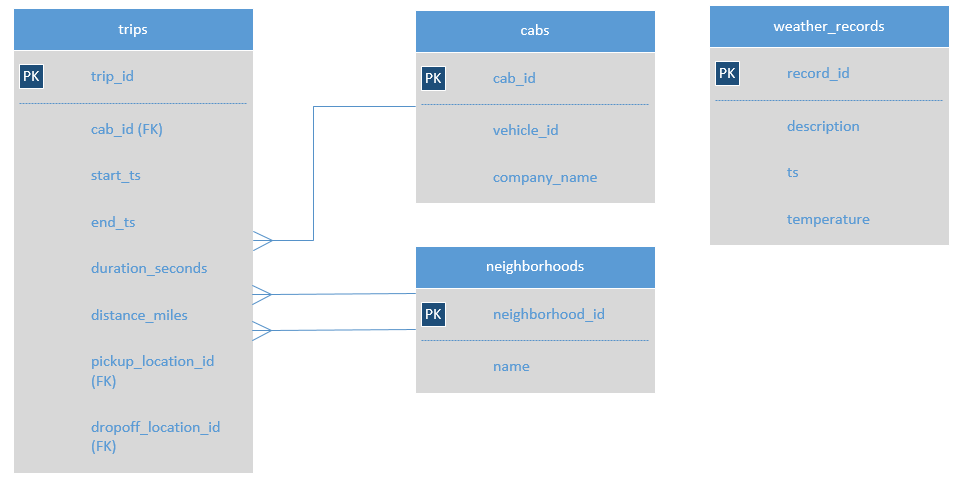

## **Paso 1. 📤 Extraer datos sobre el clima en Chicago**
---

En primer lugar, los registros meteorológicos de la ciudad de Chicago se obtendrán desde la página web [Chicago Weather 2017](https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html), utilizando la librería `requests` para acceder al contenido y el método `BeautifulSoup` de la librería `bs4` para su procesamiento.


In [1]:
# Librerías
import requests
from bs4 import BeautifulSoup
import pandas as pd


In [2]:
# Componentes de la request
URL = 'https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html'
attrs={"id": "weather_records"}

# Request
response = requests.get(URL, attrs)
soup = BeautifulSoup(response.text, 'lxml')
table = soup.find('table')

# Extrayendo nombres de columnas
column_names = []
for element in table.find_all('th'):
    column_names.append(element.text)
    
# Extrayendo contenido de cada columna
content = []
for row in table.find_all('tr'):
    if not row.find_all('th'):
        row_content = []
        for element in row:
            if element != '\n':
                row_content.append(element.text)
        content.append(row_content)

# Creando dataframe con información del clima
weather_records = pd.DataFrame(content, columns = column_names)


In [3]:
# Mostrando tabla resultado
display(weather_records)

,Date and time,Temperature,Description
0,2017-11-01 00:00:00,276.150,broken clouds
1,2017-11-01 01:00:00,275.700,scattered clouds
2,2017-11-01 02:00:00,275.610,overcast clouds
3,2017-11-01 03:00:00,275.350,broken clouds
4,2017-11-01 04:00:00,275.240,broken clouds
...,...,...,...
692,2017-11-29 20:00:00,281.340,few clouds
693,2017-11-29 21:00:00,281.690,sky is clear
694,2017-11-29 22:00:00,281.070,few clouds
695,2017-11-29 23:00:00,280.060,sky is clear


## **Paso 2. 🔍 Análisis exploratorio de datos (SQL)**
---

A continuación, se presentan las consultas SQL ejecutadas sobre la base de datos de taxis en Chicago, las cuales se utilizaron para llevar a cabo el análisis exploratorio de datos.


1. Imprime el campo `company_name`. Encuentra la cantidad de viajes en taxi para cada compañía de taxis para el 15 y 16 de noviembre de 2017, asigna al campo resultante el nombre `trips_amount` e imprímelo también. Ordena los resultados por el campo `trips_amount` en orden descendente.

In [ ]:
SELECT 
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM 
    trips
    LEFT JOIN cabs ON trips.cab_id = cabs.cab_id
WHERE 
    start_ts::date IN ('2017-11-15', '2017-11-16')
GROUP BY 
    cabs.company_name
ORDER BY 
    trips_amount DESC;

> **Comentario:**
>
> El resultado de esta consulta se almacena en el archivo 'project_sql_result_01' utilizado mas adelante.

2. Encuentra la cantidad de viajes para cada empresa de taxis cuyo nombre contenga las palabras "Yellow" o "Blue" del 1 al 7 de noviembre de 2017. Nombra la variable resultante `trips_amount`. Agrupa los resultados por el campo `company_name`.

In [ ]:
SELECT 
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM 
    trips
    INNER JOIN cabs ON trips.cab_id = cabs.cab_id
WHERE 
    start_ts::date BETWEEN '2017-11-01' AND '2017-11-07'
    AND (cabs.company_name LIKE '%Yellow%' OR cabs.company_name LIKE '%Blue%')
GROUP BY 
    cabs.company_name;

3. Del 1 al 7 de noviembre de 2017, las empresas de taxis más populares fueron "Flash Cab" y "Taxi Affiliation Services". Encuentra el número de viajes de estas dos empresas y asigna a la variable resultante el nombre `trips_amount`. Junta los viajes de todas las demás empresas en el grupo "Other". Agrupa los datos por nombres de empresas de taxis. Asigna el nombre company al campo con nombres de empresas de taxis. Ordena el resultado en orden descendente por `trips_amount`.

In [ ]:
WITH subq AS (
    SELECT 
        CASE
            WHEN cabs.company_name IN ('Flash Cab','Taxi Affiliation Services') 
            THEN cabs.company_name
            ELSE 
                'Other'
            END AS company_name,
        COUNT(trips.trip_id) AS trips_amount
    FROM 
        trips
        INNER JOIN cabs ON trips.cab_id = cabs.cab_id
    WHERE 
        start_ts::date BETWEEN '2017-11-01' AND '2017-11-07'
    GROUP BY 
        company_name
)

SELECT
    company_name,
    SUM(trips_amount) AS trips_amount
FROM 
    subq
GROUP BY 
    company_name
ORDER BY 
    trips_amount DESC

## **Paso 3. ⚖️ Prueba de hipótesis (SQL)**
---

4. Recupera los identificadores de los barrios de "O'Hare" y "Loop" de la tabla `neighborhoods`.

In [ ]:
SELECT 
    *
FROM 
    neighborhoods
WHERE 
    name LIKE '%O''Hare%' OR name LIKE 'Loop' 

5. Para cada hora recupera los registros de condiciones meteorológicas de la tabla `weather_records`. Usando el operador `CASE`, divide todas las horas en dos grupos: `Bad` si el campo description contiene las palabras "rain" o "storm", y `Good` para los demás. Nombra el campo resultante `weather_conditions`. La tabla final debe incluir dos campos: fecha y hora (`ts`) y `weather_conditions`.

In [ ]:
SELECT 
    ts,
    CASE 
        WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 
            'Bad'
        ELSE 
            'Good'
    END AS weather_conditions
FROM 
    weather_records

6. Recupera de la tabla de `trips` todos los viajes que comenzaron en el Loop (`pickup_location_id: 50`) el sábado y terminaron en O'Hare (`dropoff_location_id: 63`). Obtén las condiciones climáticas para cada viaje. Utiliza el método que aplicaste en la tarea anterior. Recupera también la duración de cada viaje. Ignora los viajes para los que no hay datos disponibles sobre las condiciones climáticas.

    Las columnas de la tabla deben estar en el siguiente orden:

    - `start_ts`
    - `weather_conditions`
    - `duration_seconds`

    Ordena por `trip_id`.

In [ ]:
WITH weather_by_hour AS (
    SELECT 
        ts,
        CASE 
            WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
            ELSE 'Good'
        END AS weather_conditions
    FROM weather_records
)

SELECT 
    trips.start_ts,
    weather_by_hour.weather_conditions,
    trips.duration_seconds
FROM trips
JOIN weather_by_hour 
    ON date_trunc('hour', trips.start_ts) = weather_by_hour.ts
WHERE 
    trips.pickup_location_id = 50
    AND trips.dropoff_location_id = 63
    AND EXTRACT(DOW FROM trips.start_ts) = 6
ORDER BY 
    trips.start_ts;

## **Paso 4. 📊 Análisis exploratorio de datos (Python)**
---

Los resultados obtenidos a partir de las consultas SQL se almacenaron en archivos `.csv`. A partir de este punto, el análisis se llevará a cabo utilizando Python y la librería `pandas`, con el apoyo del módulo `pyplot` de la librería `matplotlib` para la visualización de datos.


### **Importar los archivos**:

In [4]:
# Librerías
from matplotlib import pyplot as plt

In [5]:
# Cargando datos
trips_by_company = pd.read_csv('datasets/project_sql_result_01.csv') # Resultado 1ra consulta
neighborhood_avg_trips = pd.read_csv('datasets/project_sql_result_04.csv') 

### **Estudiar los datos que contienen:**

#### 🧾 **Dataframe `trips_by_company`**

In [6]:
print(trips_by_company.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


In [7]:
display(trips_by_company.sort_values('trips_amount', ascending=False).head(15))

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


#### 🧾 **Dataframe `neighborhood_avg_trips`**

In [8]:
print(neighborhood_avg_trips.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None


In [9]:
display(neighborhood_avg_trips.head(10))

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


> **Observaciones:**
>
> Los tipos de datos son correctos y no existen datos ausentes en ambos DataFrames.

### **Identificar los 10 principales barrios en términos de finalización del recorrido:**

In [10]:
display(
    neighborhood_avg_trips
    .sort_values(by='average_trips', ascending=False)
    .head(10)
)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


### 📈 **Gráficos.**

#### **Empresas de taxis y número de viajes:**

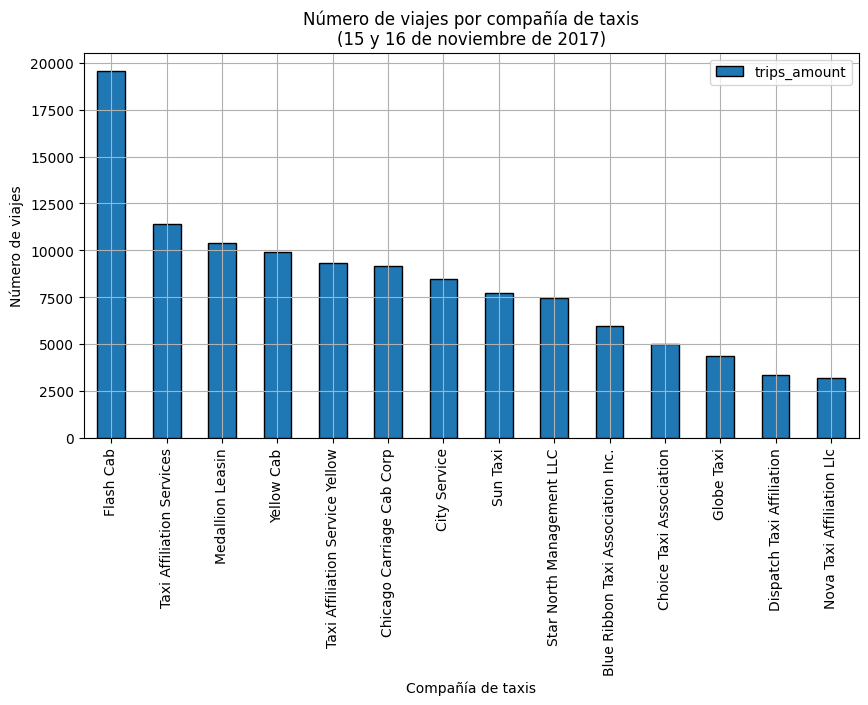

In [11]:
# Preparando el DataFrame
trips_by_company_plot = trips_by_company.query('trips_amount > 2500')

# Creando gráfico (Compañías con mayor número de servicios de taxi. Arriba de 2500.)
trips_by_company_plot.plot(
    x='company_name', xlabel='Compañía de taxis',
    y='trips_amount', ylabel='Número de viajes',
    title='Número de viajes por compañía de taxis\n(15 y 16 de noviembre de 2017)',
    kind='bar', figsize=(10,5), 
    edgecolor='black', grid=True
)

plt.show()

>**Conclusiones:**
>
>- Hay 14 compañías que realizaron mas de 2500 viajes entre el 15 y 16 de Noviembre de 2017.
>- La compañía que mas viajes realizó fué "Flash Cab" con 19,558 viajes.
>- El segundo lugar es para "Taxi Affiliation Services" con 11,422.
>- "Flash Cab" es la compañía favorita de los usuarios con diferencia, casi duplicando el volumen de servicios de su competidor mas próximo. 

#### **Los 10 barrios principales por número de finalizaciones:**

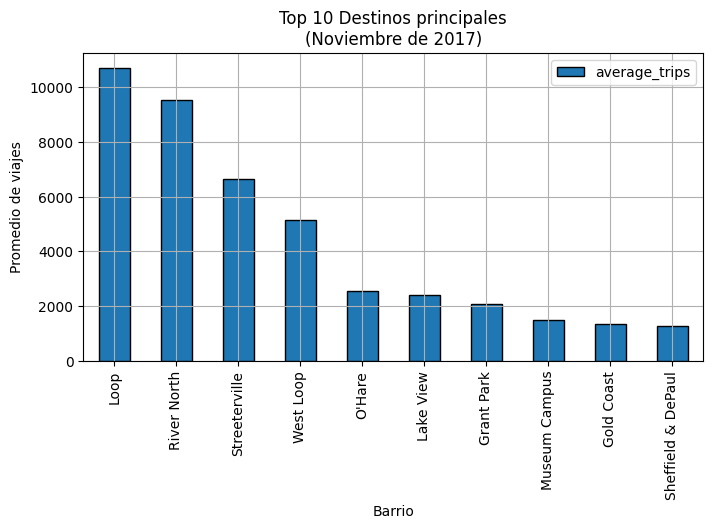

In [12]:
# Preparando el DataFrame
neighborhood_avg_trips_plot = neighborhood_avg_trips.head(10)

# Creando gráfico (Top 10 barrios destino principales)
neighborhood_avg_trips_plot.plot(
    x='dropoff_location_name', xlabel='Barrio',
    y='average_trips', ylabel='Promedio de viajes',
    title='Top 10 Destinos principales\n(Noviembre de 2017)',
    kind='bar', figsize=(8,4),
    edgecolor='black', grid=True
)

plt.show()

>**Conclusiones:**
>
>- Durante Noviembre de 2017, el destino mas popular fue el barrio "Loop" con un promedio diario de viajes de 10,727.46.
>- En segundo lugar se encuentra el barrio "River North" con un promedio de 9,523.67.
>- En tercer lugar se encuentra el barrio "Streeterville" con un promedio de 6,664.67.
>- El barrio "West Loop" esta e cuarto lugar con un pormedio de 5,163.66, es el último barrio con un promedio mayor a 5,000 viajes al día.
>- El resto de los barrios registraron promedios inferiores a 2,600 viajes diarios, y las diferencias entre ellos fueron cada vez menores.

## **Paso 5. ⚖️ Prueba de hipótesis (Python)**
---

In [13]:
# Librería
from scipy import stats

In [14]:
# Cargando archivo
loop_to_ohare = pd.read_csv('datasets/project_sql_result_07.csv')

>**El DataFrame `'loop_to_ohare'` contiene datos sobre viajes desde el Loop hasta el Aeropuerto Internacional O'Hare.** 

In [15]:
print(loop_to_ohare.info())
display(loop_to_ohare.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB
None


,start_ts,weather_conditions,duration_seconds
400,2017-11-04 14:00:00,Good,3427.0
723,2017-11-04 11:00:00,Good,2155.0
1007,2017-11-11 17:00:00,Good,2280.0
381,2017-11-18 12:00:00,Bad,2640.0
944,2017-11-04 06:00:00,Good,1462.0


>**Comprobemos la siguiente hipótesis:** *"La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos".*
>
>**Hipótesis Nula:**
>
>- *La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare son IGUALES los sábados lluviosos*
>
>**Hipótesis Alternativa:**
>
>- *La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare son DIFERENTES los sábados lluviosos*

In [16]:
# Obteniendo las poblaciones a evaluar
    # Duraciones de los viajes en sábados lluviosos
bad_weather_trips = loop_to_ohare.query('weather_conditions == "Bad"')['duration_seconds']
    # Duraciones de los viajes en sábados soleados
good_weather_trips = loop_to_ohare.query('weather_conditions == "Good"')['duration_seconds']

# Estableciendo valor alpha
alpha = 0.05

# Realizando ttest_ind()
resultado = stats.ttest_ind(bad_weather_trips, good_weather_trips, equal_var=False)

# Valor p
print(f'p_value: {resultado.pvalue}')

# Imprimiendo resultado de la prueba
if resultado.pvalue < alpha:
    print('RESULTADO: Se rechaza la hipótesis nula.')
else:
    print('RESULTADO: No se puede rechazar la hipótesis nula.')

p_value: 6.738994326108734e-12
RESULTADO: Se rechaza la hipótesis nula.


>### **Explicación:**
>- La **hipótesis nula** es aquella que busca comprobar que **no hay una diferencia significativa** entre los promedios de dos poblaciones.
>
>- La **hipótesis alternativa** busca comprobar que **si hay diferencia significativa** entre los promedios de dos poblaciones. Esta diferencia puede ser: mayor que (>), menor que(<) o como en este caso, simplemente diferente (!=).
>
>- Para realizar la pruebas de hipótesis se utilizó el método de `ttest_ind` ya que se trata de una prueba **población vs población**. Además, la evaluación de el `p_value` obtenido se realiza directamente debido a que es una prueba de **dos colas**.